In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

For data.npy

0:ProfitLoss, 1:GrossResult, 2:GrossProfitLoss, 3:Revenue, 4:Assets, 5:AverageNumberOfEmployees, 6:CurrentAssets, 7:Equity, 8:Inventories, 9:AddressOfReportingEntityPostCodeIdentifier

For data_grouped.npy

0:ProfitLoss, 1:GrossResult, 2:Assets,3:AverageNumberOfEmployees, 4:Equity, 5:AddressOfReportingEntityPostCodeIdentifier

In [4]:
data = np.load('data_grouped.npy',allow_pickle=True)
target = np.load('target_grouped.npy',allow_pickle=True)

In [5]:
#for data_grouped.npy
data = data[:,:,2:] 
target = target[:,2:]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,5] = int(str(data[i,j,5])[0])
        except:
            data[i,j,5] = 0
for i in range(target.shape[0]):
    try:
        target[i,5] = int(str(target[i,5])[0])
    except:
        target[i,5] = 0

In [6]:
# index_of_string = []
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         for k in range(data.shape[2]):
#             try:
#                 float(data[i,j,k])
#             except:
#                 index_of_string.append((i,j,k))
# index_of_string

In [7]:
data = np.delete(data,[52343,52344],axis=0)
target = np.delete(target,[52343,52344],axis=0)

In [8]:
#remove nan
nan_ = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            if np.isnan(data[i,j,k]):
                nan_.append(i)
nan_ = np.array(nan_)
nan_ = np.unique(nan_)
data = np.delete(data,nan_,axis=0)
target = np.delete(target,nan_,axis=0)

In [9]:
#removes any entry with a zero in profitloss, GrossResult, assets or equity
has_zero = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i,j,0] == 0 or data[i,j,1] == 0 or data[i,j,2] == 0 or data[i,j,4] == 0:
            has_zero.append(i)
has_zero = np.unique(np.array(has_zero))
data = np.delete(data,has_zero,axis=0)
target = np.delete(target,has_zero,axis=0)

In [10]:
data = data.astype("float")
target = target.astype("float")

In [11]:
data = torch.from_numpy(data).float()
# data = data.permute(0,2,1) # Needed if using CNN
target = torch.from_numpy(target).float()

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

train_data = data[train_idx,:,0]
train_target = target[train_idx,0] 
test_data = data[test_idx,:,0]
test_target = target[test_idx,0]

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [12]:
#for data_grouped.npy
zeros_ = np.zeros(6)
for i in range(6):
    temp = data[:,:,i].clone()
    zeros_[i] = temp[temp==0].shape[0]
    
pct_zeros = zeros_/(data.shape[0]*3)
print('0:ProfitLoss, 1:GrossResult, 2:Assets,3:AverageNumberOfEmployees, 4:Equity, 5:AddressOfReportingEntityPostCodeIdentifier')
print(pct_zeros)

0:ProfitLoss, 1:GrossResult, 2:Assets,3:AverageNumberOfEmployees, 4:Equity, 5:AddressOfReportingEntityPostCodeIdentifier
[0.         0.         0.         0.90784825 0.         0.23495961]


In [13]:
batch_size=100

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

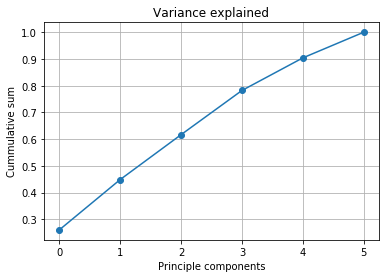

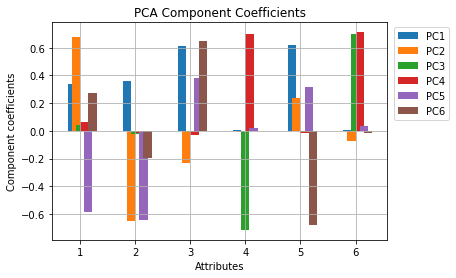

In [14]:
temp = data.clone()
temp = temp.view(temp.shape[0]*temp.shape[1],temp.shape[2])
temp = temp.numpy()

# #standardize data 
temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
temp = temp*(1/np.std(temp,0))
#compute covariance matrix
S = np.cov(temp.T)

#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(S)
idx_ord = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[idx_ord]
eigenVectors = eigenVectors[:,idx_ord]

#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(6)
for i in range(6):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig, ax = plt.subplots()
ax.plot(total_var_explained,'-o')
#ax.axhline(0.90,linestyle='--')
plt.grid();
#plt.xlim(-1,50)
#plt.ylim(0,1)
plt.title('Variance explained' )
plt.ylabel('Cummulative sum')
plt.xlabel('Principle components')
# plt.savefig("variance_explained")
plt.show()

M=6
pcs = np.arange(6)
#pcs = np.array([3,10])
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','g','b']
bw = .15
r = np.arange(1,M+1)
for i in pcs:    
   plt.bar(r+i*bw/2, eigenVectors[:,i], width=bw)
plt.xticks(r+bw, np.arange(1,13))
plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
plt.grid()
plt.title('PCA Component Coefficients')
plt.show()

In [15]:
# #Picking principle components to project the data into
# eigenvectors1 = eigenVectors[:, 0]
# eigenvectors2 = eigenVectors[:, 1]
# eigenvectors3 = eigenVectors[:, 2]
# eigenvectors4 = eigenVectors[:, 3]
# eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

# ## now we have to project our vectors in this new base
# transformed_data = temp @ eigenvectors

# fig,ax = plt.subplots(3,1,figsize=(10,15))
# ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
# ax[0].set_title('Data projection into 2D PC space')
# ax[0].set_xlabel('Principle component 1')
# ax[0].set_ylabel('Principle component 2')
# ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
# ax[1].set_title('Data projection into 2D PC space')
# ax[1].set_xlabel('Principle component 1')
# ax[1].set_ylabel('Principle component 3')
# ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
# ax[2].set_title('Data projection into 2D PC space')
# ax[2].set_xlabel('Principle component 1')
# ax[2].set_ylabel('Principle component 4')
# #plt.rcParams.update({'figure.autolayout': True})
# plt.show()

In [16]:
class RecurrentNet(nn.Module):
    def __init__(self):
        super(RecurrentNet, self).__init__()
        
        self.linearIn = nn.Sequential(nn.Linear(in_features=6,out_features=6),
                                      nn.ReLU(),
                                      nn.Linear(6,6)) 
        self.rnn = nn.LSTM(input_size=12,
                          hidden_size=50,
                          num_layers=2,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=186,out_features=140),
                                       nn.BatchNorm1d(140),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(140,70),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(70,35),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(35,20),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,3,6]
        x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
        x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
        x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
        x1 = x1.unsqueeze(1) #[batch_size,1,6]
        x2 = x2.unsqueeze(1) #[batch_size,1,6]
        x3 = x3.unsqueeze(1) #[batch_size,1,6]     
        temp = []
        temp.append(x1)
        temp.append(x2)
        temp.append(x3)
        z = torch.cat(temp,dim=1) #[batch_size,3,6]
        
        y = torch.cat((z,x),dim=2) #[batch_size,3,12]
                                            
        y,_ = self.rnn(y) #[batch_size,3,50]
        
        x = torch.cat((x,y,z),dim=2) #[batch_size,3,62]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,186]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [40]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=3,out_features=10),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.25),
                                      nn.Linear(10,20),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.25),
                                      nn.Linear(20,10),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.25),
                                      nn.Linear(10,5),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.25),
                                      nn.Linear(5,1))

        
    def forward(self, x): #x = [batch_size,3,1]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [41]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(nn.BatchNorm1d(10),
                                  nn.Conv1d(in_channels=10,out_channels=20,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(20),
                                  nn.Conv1d(20,40,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(40),
                                  nn.Conv1d(40,80,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(80),
                                  nn.Conv1d(80,160,kernel_size=3,padding=1),
                                  nn.ReLU(),
                                  nn.Conv1d(160,320,kernel_size=3,padding=0))
        
        self.linear = nn.Sequential(nn.Linear(in_features=320,out_features=160),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(160,80),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(80,40),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(40,20),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(20,1))
                                  
        
    def forward(self, x): #x = [batch_size,features,3]
        x = self.conv(x) #[batch_size,160,1]
        x = x.view(x.shape[0],-1) #[batch_size,160]
        x = self.linear(x) #[batch_size,1]
        
        x = x.view(-1) #When prediction one value
        return x

In [42]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

In [49]:
# model = ConvNet()
model = LinearNet()
# model = RecurrentNet()
model.to(device)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
critirion = nn.L1Loss()

In [50]:
#Training loop
num_epochs = 20
train_loss = []
test_loss = []

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error = 0
    model.train()   
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = critirion(output,target)
#         loss = cost(output[:,0],output[:,1], target)
#         print(loss)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        train_error += loss
        train_loss.append(loss.cpu().detach().numpy())
        
    #Comput the test accuracy
    model.eval()
    test_error = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
#         loss += cost(output[:,0],output[:,1],target)
        loss = critirion(output,target)
        test_loss.append(loss.cpu().detach().numpy())
        test_error += loss
    train_err = train_error/len(trainset)
    test_err = test_error/len(testset)
    print("train error: {train:.1f}\t test error: {test:.1f}".format(test=test_err, train=train_err))


train error: 23875.9	 test error: 20234.4



train error: 20908.8	 test error: 18156.3



train error: 20863.9	 test error: 16825.1



train error: 21444.3	 test error: 17465.5



train error: 19991.7	 test error: 17192.3



train error: 20154.0	 test error: 16677.1



train error: 20539.6	 test error: 17800.0



train error: 20906.9	 test error: 16762.8



train error: 21228.1	 test error: 15934.6



train error: 20491.1	 test error: 16593.7



train error: 19967.5	 test error: 16418.4



train error: 20420.2	 test error: 15964.7



train error: 19846.7	 test error: 16344.6



train error: 20186.6	 test error: 16055.2



train error: 20156.1	 test error: 16344.2



train error: 20399.5	 test error: 16166.3



train error: 19820.9	 test error: 16205.5



train error: 18981.2	 test error: 16304.4



train error: 19524.2	 test error: 16319.2



train error: 19855.1	 test error: 16057.9



In [51]:
print(target)
temp =model(data)
print(temp)

tensor([159145.,  10888.], device='cuda:0')
tensor([4.0461e+04, 2.0384e+00], device='cuda:0', grad_fn=<ViewBackward>)


In [52]:
#predicts the average over the last 3 years
baseline_loss = 0
for minibatch_no, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):  
#     y_pred = data[:,:,0].mean(1)
    y_pred = data.mean(1)
    loss = critirion(y_pred,target)
    baseline_loss += loss.numpy()
baseline_loss /= len(trainset)
print("baseline error: {error:.1f}".format(error =baseline_loss))


baseline error: 1974.9


In [ ]:
# torch.save(model.state_dict(),"Current_Assets")